[ 2.00e-01 -2.08e+02]


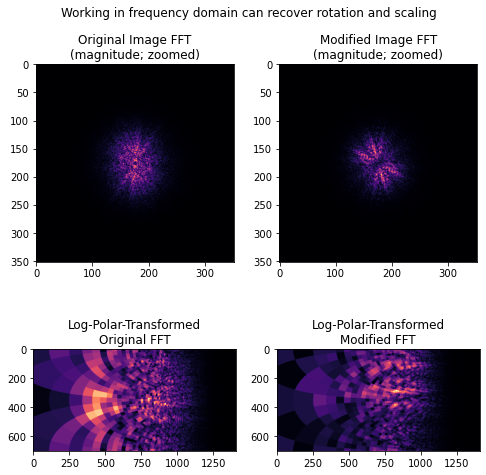

Expected value for cc rotation in degrees: 24
Recovered value for cc rotation: 0.05102763997165131

Expected value for scaling difference: 1.4
Recovered value for scaling difference: 0.46663985889861054


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float

from skimage.color import rgb2gray
from skimage.filters import window, difference_of_gaussians
from scipy.fft import fft2, fftshift

angle = 24
scale = 1.4
shiftr = 30
shiftc = 15

image = rgb2gray(data.retina())
translated = image[shiftr:, shiftc:]
rotated = rotate(translated, angle)
rescaled = rescale(rotated, scale)
sizer, sizec = image.shape
rts_image = rescaled[:sizer, :sizec]

# First, band-pass filter both images
image = difference_of_gaussians(image, 5, 20)
rts_image = difference_of_gaussians(rts_image, 5, 20)

# window images
wimage = image * window('hann', image.shape)
rts_wimage = rts_image * window('hann', image.shape)

# work with shifted FFT magnitudes
image_fs = np.abs(fftshift(fft2(wimage)))
rts_fs = np.abs(fftshift(fft2(rts_wimage)))

# Create log-polar transformed FFT mag images and register
shape = image_fs.shape
radius = shape[0] // 8  # only take lower frequencies
warped_image_fs = warp_polar(image_fs, radius=radius, output_shape=shape,
                             scaling='log', order=0)
warped_rts_fs = warp_polar(rts_fs, radius=radius, output_shape=shape,
                           scaling='log', order=0)

warped_image_fs = warped_image_fs[:shape[0] // 2, :]  # only use half of FFT
warped_rts_fs = warped_rts_fs[:shape[0] // 2, :]
shifts, error, phasediff = phase_cross_correlation(warped_image_fs,
                                                   warped_rts_fs,
                                                   upsample_factor=10)

# Use translation parameters to calculate rotation and scaling parameters
shiftr, shiftc = shifts[:2]
recovered_angle = (360 / shape[0]) * shiftr
klog = shape[1] / np.log(radius)
shift_scale = np.exp(shiftc / klog)

print(shifts)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.ravel()
ax[0].set_title("Original Image FFT\n(magnitude; zoomed)")
center = np.array(shape) // 2
ax[0].imshow(image_fs[center[0] - radius:center[0] + radius,
                      center[1] - radius:center[1] + radius],
             cmap='magma')
ax[1].set_title("Modified Image FFT\n(magnitude; zoomed)")
ax[1].imshow(rts_fs[center[0] - radius:center[0] + radius,
                    center[1] - radius:center[1] + radius],
             cmap='magma')
ax[2].set_title("Log-Polar-Transformed\nOriginal FFT")
ax[2].imshow(warped_image_fs, cmap='magma')
ax[3].set_title("Log-Polar-Transformed\nModified FFT")
ax[3].imshow(warped_rts_fs, cmap='magma')
fig.suptitle('Working in frequency domain can recover rotation and scaling')
plt.show()

print(f'Expected value for cc rotation in degrees: {angle}')
print(f'Recovered value for cc rotation: {recovered_angle}')
print()
print(f'Expected value for scaling difference: {scale}')
print(f'Recovered value for scaling difference: {shift_scale}')

In [ ]:
from skimage.transform import SimilarityTransform
tform = SimilarityTransform(translation=(0, -10))
warped = warp(image, tform)

In [ ]:
warped.shape

In [ ]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/schiend/Desktop/DOHERTY/R-workspace/cecelia/inst')

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [ ]:
base_dir = '/Volumes/Analysis_SSD/Dominik/cecelia/projects/wEsnzt/ANALYSIS/'

In [ ]:
# Kidney
im_paths = [
    os.path.join(base_dir, '0', '4Fw66S','ccidImage.ome.zarr'),
    os.path.join(base_dir, '0', 'zCqv1H','ccidImage.ome.zarr'),
    #os.path.join(base_dir, '0', 'pctYMs','ccidImage.ome.zarr'),
    os.path.join(base_dir, '0', 'fEn4xi','ccidImage.ome.zarr')
]
channel_ids = [0, 0, 0]

In [ ]:
# Spleen
im_paths = [
    os.path.join(base_dir, '0', 'n22foC','ccidImage.ome.zarr'),
    os.path.join(base_dir, '0', 'kqmZjJ','ccidImage.ome.zarr'),
    #os.path.join(base_dir, '0', '5gG1iw','ccidImage.ome.zarr'),
    os.path.join(base_dir, '0', 'n1DVkY','ccidImage.ome.zarr')
]
channel_ids = [2, 3, 2]

In [ ]:
# Liver
im_paths = [
    os.path.join(base_dir, '0', 'SXejeM','ccidImage.ome.zarr'),
    os.path.join(base_dir, '0', 'Iksums','ccidImage.ome.zarr'),
    os.path.join(base_dir, '0', 'PTsqyH','ccidImage.ome.zarr'),
    os.path.join(base_dir, '0', 'OO0Q6w','ccidImage.ome.zarr')
]
channel_ids = [3, 3, 3, 3]

In [ ]:
import py.zarr_utils as zarr_utils
import py.ome_xml_utils as ome_xml_utils
from py.dim_utils import DimUtils
import py.correction_utils as correction_utils

In [ ]:
import napari

viewer = napari.Viewer()

In [ ]:
# show alignment
reg_im = zarr_utils.open_as_zarr('/Volumes/Analysis_SSD/Dominik/TMP/reg000.zarr')

colors = ['gray', 'magenta', 'cyan', 'yellow']
#for i, x in enumerate([3, 10, 17, 24]):
for i, x in enumerate([3, 10]):
    viewer.add_image(reg_im[0][0][0, x, :, :, :], colormap=colors[i], blending='additive')

In [ ]:
# get image information
im_zarrs = [zarr_utils.open_as_zarr(x, as_dask = True) for x in im_paths]
im_zarrs = [x[0] for x in im_zarrs]

In [ ]:
# create dim utils for images
dim_utils = [
    DimUtils(ome_xml_utils.parse_meta(x), use_channel_axis = True) for x in im_paths
]

for i, x in enumerate(dim_utils):
    x.calc_image_dimensions(im_zarrs[i][0].shape)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
import zarr

from skimage.color import separate_stains, combine_stains, hdx_from_rgb, rgb_from_hdx
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale, warp, SimilarityTransform, AffineTransform
from skimage.util import img_as_float

In [ ]:
"""
Get shifts for image registration
"""
def image_registration_shifts(ims, channel_ids, radius = 1000, upsample_factor = 20):
    # warp image for rotation
    im_polar = warp_polar(np.amax(ims[0], axis = 0), radius = radius, scaling = 'log')
    
    shifts = list()
    rotations = list()
    
    # go through images and find shifts based on first image
    for i in range(1, len(ims)):
        # apply translation shifts
        shift, error, diffphase = phase_cross_correlation(ims[0], ims[i], upsample_factor = upsample_factor)
        shifts.append(shift)
        
        tform = SimilarityTransform(translation = (-shift[0], -shift[1]))
        im_warped = warp(ims[i], tform)

        # apply rotation
        other_polar = warp_polar(np.amax(im_warped, axis = 0), radius = radius, scaling = 'log')

        shift, error, diffphase = phase_cross_correlation(im_polar, other_polar, upsample_factor = upsample_factor)
        rotations.append(shift)

        tform = AffineTransform(rotation = math.radians(-shift[0]))
        im_warped = warp(im_warped, tform)

        # apply translation shifts
        shift, error, diffphase = phase_cross_correlation(ims[0], im_warped, upsample_factor = upsample_factor)
        shifts[-1] = shifts[-1] + shift
    
    # convert to array
    return np.vstack(shifts), np.vstack(rotations)

In [ ]:
"""
Register image
"""
def im_registration(
    input_arrays, dim_utils_list, phase_shift_channels,
    reg_path = None, normalise_percentile = 98,
    upsample_factor = 100, shifts = None):
    

In [ ]:
input_arrays = im_zarrs
dim_utils_list = dim_utils
phase_shift_channels = channel_ids
reg_path = '/Volumes/Analysis_SSD/Dominik/TMP/reg000'
shifts = None
upsample_factor = 20
normalise_percentile = 98

In [ ]:
# get shifts
if shifts is None:
    print('>> Get shifts')
    # get shifts from lowest res
    low_res = len(input_arrays[0]) - 1

    im_slices = [0 for _ in range(len(input_arrays[0][0].shape))]
    im_slices[dim_utils_list[0].dim_idx('X')] = slice(0, min([x.dim_val('X', scale = low_res) for x in dim_utils_list]))
    im_slices[dim_utils_list[0].dim_idx('Y')] = slice(0, min([x.dim_val('Y', scale = low_res) for x in dim_utils_list]))

    if dim_utils_list[0].is_3D() is True:
        im_slices[dim_utils_list[0].dim_idx('Z')] = slice(None)

    # get low resolution images for registration
    ims = list()

    for i, x in enumerate(input_arrays):
        im_slices[dim_utils[i].dim_idx('C')] = phase_shift_channels[i]
        ims.append(zarr_utils.fortify(x[low_res][tuple(im_slices)]))

        # normalise image
        percentile = (np.percentile(ims[-1], normalise_percentile),
                      np.percentile(ims[-1], 100 - normalise_percentile))
        ims[-1] = ((ims[-1] - percentile[1]) / (percentile[0] - percentile[1]))

    # get shifts and rotations
    shifts, rotations = image_registration_shifts(
        ims, phase_shift_channels,
        upsample_factor = upsample_factor)

In [ ]:
# get shifts summary
shifts_summary = correction_utils.shifts_summary(shifts, cumulative = False)

# get new image dimensions
reg_im_shape, reg_im_shape_round = correction_utils.correction_im_shape(
    input_arrays[0][0], dim_utils_list[0], shifts_summary
)

# get first image position
first_im_pos = correction_utils.correction_first_im_pos(
    reg_im_shape, dim_utils_list[0], shifts_summary
)

In [ ]:
first_im_pos

In [ ]:
# remove previous folder
if reg_path is not None and os.path.exists(reg_path) is True:
    shutil.rmtree(reg_path)

# add channels for new image
reg_im_shape_round = list(reg_im_shape_round)
# remove channel for registration from sum?
#reg_im_shape_round[dim_utils_list[0].dim_idx('C')] = sum([x.dim_val('C') - 1 for x in dim_utils_list]) + 1
reg_im_shape_round[dim_utils_list[0].dim_idx('C')] = sum([x.dim_val('C') for x in dim_utils_list])
reg_im_shape_round = tuple(reg_im_shape_round)

# create array
reg_zarr = zarr.create(
    reg_im_shape_round,
    dtype = input_arrays[0][0].dtype,
    chunks = input_arrays[0][0].chunksize,
    store = reg_path
)

# use first position for slice
slices = first_im_pos

In [ ]:
print('>> Apply shifts')

# go through images and register to first image
for i, x in enumerate(input_arrays):
    # create slice
    if i > 0:
        new_slices = list()

        # adjust slices
        for j, y in enumerate(slices):
            new_slices.append(slice(
              # subtract '1' because there is no
              # shift for the first frame
              y.start + shifts[i - 1, j],
              y.stop + shifts[i - 1, j],
              1
            ))

        # push back
        slices = new_slices

    # round for slicing
    new_slices = [slice(None) for _ in range(len(reg_im_shape_round))]

    # set Z, X, Y for new slices
    for j, y in enumerate(('Z', 'Y', 'X')):
        new_slices[dim_utils_list[i].dim_idx(y)] =  slice(round(slices[j].start), round(slices[j].stop), 1)

    # set channel for new slice
    prev_channels = sum([x.dim_val('C') for x in dim_utils_list[0:i]])
    new_slices[dim_utils_list[i].dim_idx('C')] = slice(
        prev_channels, prev_channels + dim_utils_list[i].dim_val('C'), 1)

    # convert to tuple
    new_slices = tuple(new_slices)
    
    print(f'>> reg {i}')
    print(f'> {new_slices}')

    # add to image list
    new_image = np.zeros(reg_im_shape_round)

    # check that slices match dimension
    if new_image[new_slices].shape != x[0].shape:
        # get wrong dimensions
        dif_dim = [x - y for x, y in zip(
            new_image[new_slices].shape,
            x[0].shape
        )]

        # adjust dimensions
        new_slices = list(new_slices)

        for j, y in enumerate(dif_dim):
            if y > 0:
              # add?
              new_slices[j] = slice(
                  new_slices[j].start + y,
                  new_slices[j].stop, 1)

            if y < 0:
              # add?
              if new_slices[j].start - y >= 0:
                new_slices[j] = slice(
                  new_slices[j].start + y,
                  new_slices[j].stop, 1)

              # subtract?
              elif new_slices[j].stop + y < reg_zarr.shape[j]:
                new_slices[j] = slice(
                  new_slices[j].start,
                  new_slices[j].stop + y, 1)

        new_slices = tuple(new_slices)

    # apply rotation and push to zarr
    reg_zarr[new_slices] = warp(x[0], AffineTransform(rotation = math.radians(-rotations[i - 1][0])))

In [ ]:
im_registration(im_zarrs, dim_utils, channel_ids, reg_path)

In [ ]:
# prepare image to compare
before_rgb_im = combine_stains(np.dstack([np.amax(x, axis = 0) for x in ims]), rgb_from_hdx)

In [ ]:
# merge signal
after_rgb_im = combine_stains(np.dstack(np.amax(x, axis = 0) for x in warped_im), rgb_from_hdx)
after_rgb_zoom = combine_stains(np.dstack(np.amax(x, axis = 0) for x in warped_zarr), rgb_from_hdx)

fig, axes = plt.subplots(2, 2, figsize=(40, 40))
ax = axes.ravel()
ax[0].set_title("Nuclei")

show_slices[dim_utils[0].dim_idx('C')] = channel_ids[0]
ax[0].set_title("Before")
ax[0].imshow(before_rgb_im)
ax[1].set_title("Aligned")
ax[1].imshow(after_rgb_im)
ax[2].set_title("Before")
ax[2].imshow(before_rgb_zoom)
ax[3].set_title("Aligned")
ax[3].imshow(after_rgb_zoom)
plt.show()